In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az

# regular GLMs
import pingouin as pg
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [3]:
## Load amygdala database
df = pd.read_csv('FCallSessions.csv')
# create a long format for analysis
df.describe()

,groupIdx,amg_hippPost1,amg_vmPFC1,amg_HippAnt1,amg_vmPFCAnt1,hippAnt_vmPFCAnt1,hippAnt_hippPost1,amg_hippPost2,amg_vmPFC2,amg_hippAnt2,amg_vmPFCAnt2,hippAnt_vmPFCAnt2,hippAnt_hippPost2,amg_hippPost3,amg_vmPFC3,amg_hippAnt3,amg_vmPFCAnt3,hippAnt_vmPFCAnt3,hippAnt_hippPost3
count,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000
mean,0.518519,0.285492,0.512272,0.269575,0.349221,0.213174,0.305449,0.286525,0.360390,0.306771,0.230139,0.242307,0.273948,0.338102,0.409253,0.271146,0.214985,0.178116,0.425026
std,0.509175,0.208424,0.221939,0.258476,0.218027,0.296783,0.251906,0.295561,0.215478,0.241151,0.226912,0.282460,0.259970,0.306003,0.219302,0.267546,0.292768,0.299988,0.193779
min,0.000000,-0.096844,-0.055699,-0.192782,-0.349564,-0.469990,-0.250251,-0.254465,-0.272251,-0.214743,-0.229349,-0.443330,-0.130521,-0.366046,-0.146157,-0.189834,-0.385748,-0.460460,-0.029337
25%,0.000000,0.134673,0.354129,0.143131,0.258047,0.094840,0.176490,0.043544,0.245561,0.094251,0.137181,0.134233,0.068577,0.143829,0.290851,0.094045,0.066558,0.014552,0.289250
50%,1.000000,0.281188,0.568741,0.258664,0.381235,0.232867,0.330019,0.356874,0.363085,0.351817,0.249799,0.271290,0.204436,0.309572,0.479818,0.301530,0.249703,0.176067,0.489939
75%,1.000000,0.443839,0.670424,0.392993,0.476364,0.392850,0.519965,0.539539,0.486812,0.497305,0.387631,0.427041,0.509306,0.567329,0.551353,0.448451,0.413853,0.458328,0.550105
max,1.000000,0.658449,0.774370,0.750596,0.646947,0.662831,0.648514,0.698112,0.675950,0.733511,0.584931,0.653689,0.848090,0.807860,0.753866,0.751112,0.740254,0.662622,0.694430


## Amygdala Hippocampus

In [4]:
#vars = ['amg_HippAnt1', 'amg_hippAnt2', 'amg_hippAnt3', 'amg_hippAnt4']
df_long = pd.melt(df, id_vars=['scr_id','groupIdx'], value_vars=['amg_hippPost1','amg_hippPost2',
                                                                         'amg_hippPost3'])

In [5]:
df_long.groupby(['groupIdx', 'variable']).describe()

value                                          \
                       count      mean       std       min       25%   
groupIdx variable                                                      
0        amg_hippPost1  13.0  0.232713  0.156011  0.005189  0.108381   
         amg_hippPost2  12.0  0.438861  0.180178  0.073380  0.381203   
         amg_hippPost3  10.0  0.292109  0.357691 -0.366046  0.101157   
1        amg_hippPost1  14.0  0.334501  0.242985 -0.096844  0.172942   
         amg_hippPost2  14.0  0.155951  0.317396 -0.254465 -0.104551   
         amg_hippPost3  12.0  0.376429  0.265625 -0.131075  0.229355   

                                                      
                             50%       75%       max  
groupIdx variable                                     
0        amg_hippPost1  0.234275  0.332985  0.494981  
         amg_hippPost2  0.472924  0.578617  0.633108  
         amg_hippPost3  0.229846  0.567329  0.788340  
1        amg_hippPost1  0.353047  0.540697  0.658449  
         amg_hippPost2  0.078807  0.368853  0.698112  
         amg_hippPost3  0.396978  0.505380  0.807860

In [6]:
glm = smf.mixedlm('value ~ variable * groupIdx', data=df_long, groups = df_long.scr_id, 
                 missing='drop')
model1 = glm.fit()
print(model1.summary())

                    Mixed Linear Model Regression Results
Model:                     MixedLM        Dependent Variable:        value   
No. Observations:          75             Method:                    REML    
No. Groups:                27             Scale:                     0.0608  
Min. group size:           2              Log-Likelihood:            -12.1202
Max. group size:           3              Converged:                 Yes     
Mean group size:           2.8                                               
-----------------------------------------------------------------------------
                                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------
Intercept                           0.233    0.072  3.232 0.001  0.092  0.374
variable[T.amg_hippPost2]           0.203    0.099  2.055 0.040  0.009  0.397
variable[T.amg_hippPost3]           0.058    0.104  0.560 0.576 -0.146  0.263
groupI

/gpfs/ysm/project/joormann/oad4/conda_envs/pymc4/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [7]:
# mixed anova
aov = pg.mixed_anova(data=df_long, dv='value', between='groupIdx', within='variable',
                     subject='scr_id', correction=False, effsize="np2")
pg.print_table(aov)


ANOVA SUMMARY

Source          SS    DF1    DF2     MS      F    p-unc    np2      eps
-----------  -----  -----  -----  -----  -----  -------  -----  -------
groupIdx     0.042      1     19  0.042  0.452    0.509  0.023  nan
variable     0.052      2     38  0.026  0.421    0.660  0.022    0.971
Interaction  0.263      2     38  0.132  2.146    0.131  0.101  nan



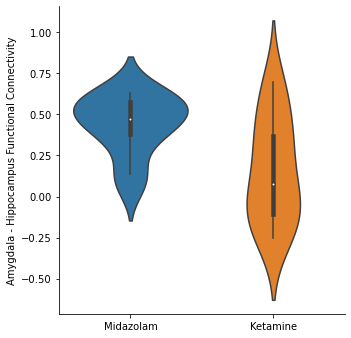

In [8]:
# simple boxplot graph
a = sns.catplot(y='amg_hippPost2', x='groupIdx', data= df, kind='violin')
a.set_xticklabels(labels = ["Midazolam", "Ketamine"])
a.set_xlabels("")
a.set_ylabels("Amygdala - Hippocampus Functional Connectivity")
a.savefig('amg_postHipp_FC_time2.png', dpi=300, bbox_inches='tight')

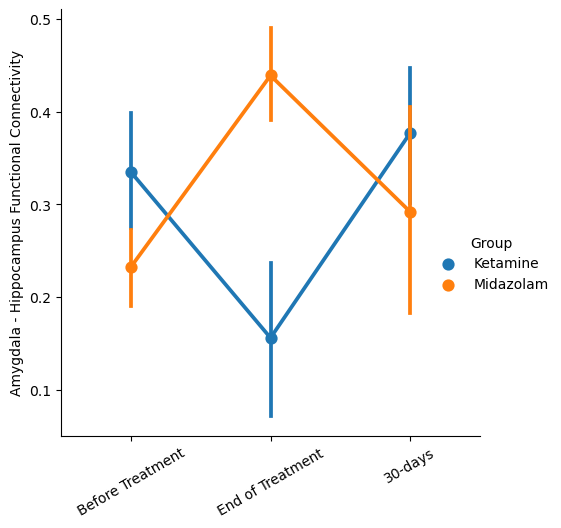

In [9]:
g = sns.catplot(y='value',x='variable', hue='groupIdx', data=df_long, kind='point', ci=68,
               hue_order=[1,0])
g.set_xlabels("")
g.set_xticklabels(
    labels=["Before Treatment", "End of Treatment", "30-days"], rotation=30)

g.set_ylabels("Amygdala - Hippocampus Functional Connectivity")
g._legend.set_title("Group")
new_labels = ['Ketamine', 'Midazolam']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)
g.savefig('amg_postHipp_FC.png', dpi=300, bbox_inches='tight')

In [ ]:
pg.ttest(df.amg_hippPost2[df['groupIdx']==1], df.amg_hippPost2[df['groupIdx']==0], correction=False)

# Interaction model

In [10]:
df_long2 = pd.melt(df, id_vars=['scr_id','groupIdx', 'amg_hippPost1'], value_vars=['amg_hippPost2','amg_hippPost3'])
#df_long2

In [11]:
# take indexes for building the model
df_long2['scr_id'] = df_long2.scr_id.astype('category')
sub_idx = df_long2.scr_id.cat.codes.values 
print(sub_idx)
n_subs = len(np.unique(df_long2.scr_id))
print(n_subs)
# set time as index also
#df_long.groupIdx = pd.Categorical(df_long.groupIdx)
df_long2.variable = pd.Categorical(df_long2.variable, 
                    categories=['amg_hippPost2','amg_hippPost3'])
timeIDX = df_long2.variable.cat.codes.values
print(timeIDX)
df_long2['time'] = timeIDX


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20
 21 22 23 24 25 26]
27
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [12]:
from utils import runModel

In [13]:
import importlib
import utils
importlib.reload(utils)

<module 'utils' from '/gpfs/ysm/home/oad4/KPE/func/fc/utils.py'>

In [14]:
trace = runModel(df_long2, 'amg_hippPost1', timeIDX)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, cov, b, interaction, eps, likelihood_missing]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 28 seconds.


In [15]:
az.summary(trace, hdi_prob = .95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],0.026,0.090,-0.161,0.198,0.001,0.001,16703.0,5530.0,1.0
a[1],0.033,0.089,-0.148,0.200,0.001,0.001,16062.0,6006.0,1.0
a[2],0.019,0.094,-0.164,0.199,0.001,0.001,17037.0,6868.0,1.0
a[3],-0.032,0.088,-0.204,0.141,0.001,0.001,16458.0,5444.0,1.0
a[4],-0.024,0.088,-0.198,0.148,0.001,0.001,20097.0,5302.0,1.0
a[5],-0.002,0.089,-0.177,0.171,0.001,0.001,19009.0,5663.0,1.0
a[6],-0.016,0.094,-0.194,0.180,0.001,0.001,15254.0,5806.0,1.0
a[7],0.108,0.093,-0.079,0.284,0.001,0.001,16459.0,5463.0,1.0
a[8],-0.006,0.091,-0.186,0.171,0.001,0.001,17277.0,5203.0,1.0
a[9],0.009,0.089,-0.173,0.173,0.001,0.001,18231.0,6022.0,1.0


({'BF10': array([7.59088835]), 'BF01': array([0.13173689])},
 <Axes: title={'center': 'The BF_10 is 7.59\nThe BF_01 is 0.13'}, xlabel='effect size2_1', ylabel='Density'>)

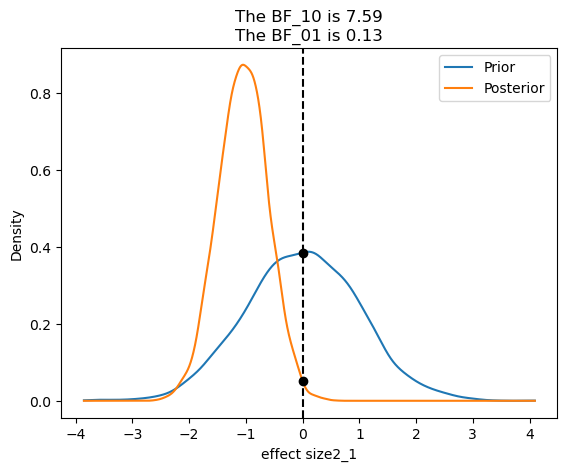

In [16]:
# Bayes Factor
az.plot_bf(trace, var_name = 'effect size2_1', prior = np.random.normal(0, 1, 5000))

({'BF10': array([0.55277082]), 'BF01': array([1.80906799])},
 <Axes: title={'center': 'The BF_10 is 0.55\nThe BF_01 is 1.81'}, xlabel='effect size3_1', ylabel='Density'>)

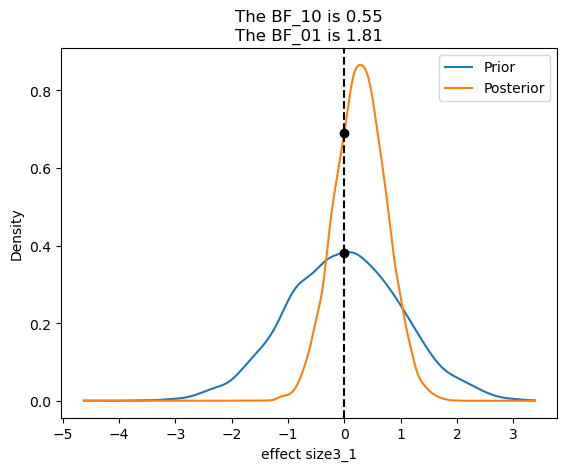

In [17]:
az.plot_bf(trace, var_name = 'effect size3_1', prior = np.random.normal(0, 1, 5000))

In [ ]:
with pm.Model() as hierarchical:
      
    a = pm.Normal('a', mu=0, sd=0.5, shape=n_subs)
       
    b = pm.Normal('b', mu=0, sd=0.5, shape=3)
   
    # Model error
    eps = pm.HalfCauchy('eps', 3)

    y_hat = a[sub_idx] + b[timeIDX]

    # Data likelihood
    likelihood = pm.Normal('likelihood', mu=y_hat,
                           sigma=eps, observed=df_long.value)
    
    trace = pm.sample(draws=4000, tune=2000, target_accept=0.9, return_inferencedata=False)

In [ ]:
az.plot_trace(trace)

In [ ]:
az.summary(trace, hdi_prob=.9)

In [ ]:
diff = trace['b'][:,1] - trace['b'][:,0]
sns.distplot(diff)
print(f'{sum(diff>0)/len(diff)}')

In [ ]:
diff = trace['b'][:,2] - trace['b'][:,0]
sns.distplot(diff)
print(f'{sum(diff>0)/len(diff)}')

In [ ]:
with pm.Model() as model_glm:
    pm.GLM.from_formula('amg_hippPost1 ~ groupIdx', df)
    traceSes1 = pm.sample(return_inferencedata=True)
az.summary(traceSes1, hdi_prob=.9)

In [ ]:
with pm.Model() as model_glm:
    pm.GLM.from_formula('amg_hippPost2 ~ groupIdx', df)
    traceSes2 = pm.sample(return_inferencedata=True)
az.summary(traceSes2, hdi_prob=.9)

In [ ]:
with pm.Model() as model_glm:
    pm.GLM.from_formula('amg_hippPost3 ~ groupIdx', df)
    traceSes3 = pm.sample(return_inferencedata=True)
az.summary(traceSes3, hdi_prob=.9)

- Between amygdala and posterior hippocampus there's a difference only after treatment. With Ketamine shows lower connectivity, compared to midazolam.

## Amygdala and vmPFC

In [ ]:
# simple boxplot graph
a = sns.catplot(y='amg_vmPFC2', x='groupIdx', data= df, kind='violin')
a.set_xticklabels(labels = ["Midazolam", "Ketamine"])
a.set_xlabels("")
a.set_ylabels("Amygdala - vmPFC Functional Connectivity")
a.savefig('amg_vmPFC_FC_time2.png', dpi=300, bbox_inches='tight')

In [ ]:
pg.ttest(df.amg_vmPFC2[df.groupIdx==1], df.amg_vmPFC2[df.groupIdx==0], 
         paired=False, correction=False)

In [ ]:
df_long = pd.melt(df, id_vars=['scr_id','groupIdx'], value_vars=['amg_vmPFC1','amg_vmPFC2',
                                                                         'amg_vmPFC3'])

In [ ]:
df_long.groupby(['groupIdx','variable']).describe()

In [ ]:
sns.set(font_scale = 1.1)
sns.set_style("white")
g = sns.catplot(y='value',x='variable', hue='groupIdx', data=df_long, kind='point',
           ci=68, hue_order=[1,0])
g.set_xlabels("")
g.set_xticklabels(
    labels=["Before Treatment", "End of Treatment", "30-days"], rotation=30)

g.set_ylabels("Amygdala - vmPFC Functional Connectivity")
g._legend.set_title("Group")
new_labels = ['Ketamine','Midazolam']
#leg = plt.legend(loc="upper right", frameon=False, fontsize=15, labels=new_labels)
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

g.savefig('amg_vmpfc_FC.png', dpi=600, bbox_inches='tight')

In [ ]:
aov = pg.mixed_anova(data=df_long, dv='value', between='groupIdx', within='variable',
                     subject='scr_id', effsize="np2")
pg.print_table(aov)

In [ ]:
glm = smf.mixedlm('value ~ C(variable) * C(groupIdx)', data=df_long, groups = df_long.scr_id, 
                 missing='drop')
model1 = glm.fit()
print(model1.summary())

In [ ]:
# take indexes for building the model
df_long['scr_id'] = df_long.scr_id.astype('category')
sub_idx = df_long.scr_id.cat.codes.values # get county category index values (613 x 1) vec with nums [0-7]
print(sub_idx)
n_subs = len(np.unique(df_long.scr_id))
print(n_subs)
# set time as index also
#df_long.groupIdx = pd.Categorical(df_long.groupIdx)
df_long.variable = pd.Categorical(df_long.variable, 
                    categories=['amg_vmPFC1','amg_vmPFC2', 'amg_vmPFC3'])
timeIDX = df_long.variable.cat.codes.values
print(timeIDX)
df_long['time'] = timeIDX

In [ ]:
with pm.Model() as hierarchical:
      
    a = pm.Normal('a', mu=0, sd=0.5, shape=n_subs)
       
    b = pm.Normal('b', mu=0, sd=0.5, shape=3)

    # Model error
    eps = pm.HalfCauchy('eps', 3)

    y_hat = a[sub_idx] + b[timeIDX] 

    # Data likelihood
    likelihood = pm.Normal('likelihood', mu=y_hat,
                           sigma=eps, observed=df_long.value)
    
    trace = pm.sample(draws=1000, tune=1000, target_accept=0.9, return_inferencedata=False)

In [ ]:
# look at difference between before/after
az.summary(trace)

In [ ]:
az.plot_posterior(trace['b'][:,1] - trace['b'][:,0], kind='hist',ref_val=0)
az.plot_posterior(trace['b'][:,2] - trace['b'][:,0], kind='hist',ref_val=0)

In [ ]:
# an interaction model
with pm.Model() as hierarchical:
      
    a = pm.Normal('a', mu=0, sd=0.1, shape=n_subs)
    b = pm.Normal('b', mu=0, sd=0.1, shape=3)
    
    
   # bMed = pm.Normal('bMed', mu=0, sd=0.1, shape=2) #
    interact = pm.Normal('interaction', mu=0, sd=0.1, shape=(3,2))
  
    # Model error
    eps = pm.HalfCauchy('eps', 1)

    y_hat = a[sub_idx] + b[timeIDX] + interact[timeIDX,df_long.groupIdx] 
    # Data likelihood
    likelihood = pm.Normal('likelihood', mu=y_hat,
                           sigma=eps, observed=df_long.value)
    
    ppChecks = pm.sample_prior_predictive(samples = 2000)
    trace2 = pm.sample(draws=2000, tune=1000, target_accept=0.9, return_inferencedata=True, cores=4)

In [ ]:
az.summary(trace2, hdi_prob=.9)

In [ ]:
# compare 
tr = trace2.posterior.stack(draws=("chain", "draw"))
sns.distplot(tr.interaction.values[0,1,:,], label='Ketamin before')
sns.distplot(tr.interaction.values[1,1,:], label = 'Ketamine After')
sns.distplot(tr.interaction.values[2,1,:], label = 'Ketamine 30-days')
plt.legend()

In [ ]:
after = (tr.interaction.values[2,1,:,] - tr.interaction.values[0,1,:,])# / np.sqrt(
az.plot_posterior(after, kind='hist', ref_val=0)
print(np.sum(after>=0) / len(after))

In [ ]:
after = (tr.interaction.values[2,0,:,] - tr.interaction.values[0,0,:,])# / np.sqrt(
az.plot_posterior(after, kind='hist', ref_val=0)
print(np.sum(after>=0) / len(after))

In [ ]:
# mean across groups
after = (np.mean(tr.interaction.values[1,:,:,], axis=0) - np.mean(tr.interaction.values[0,:,:,], axis=0))# / np.sqrt(
az.plot_posterior(after, kind='hist', ref_val=0)
print(np.sum(after>=0) / len(after))

In [ ]:
## Generate model with difference sampling as well
with pm.Model() as model2:
      
    a = pm.Normal('a', mu=0, sd=0.5, shape=n_subs)
    
    # adding sd for each 
    #sigma = pm.HalfNormal('sigma_before', .5, shape=3)
        
    b = pm.Normal('b', mu=0, sd=.5, shape=3)

    # Model error
    eps = pm.HalfCauchy('eps', 3)

    y_hat = a[sub_idx] + b[timeIDX] 

    # Data likelihood
    likelihood = pm.Normal('likelihood', mu=y_hat,
                           sigma=eps, observed=df_long.value)
 
    # difference between
    diff_of_means_bfrAftr = pm.Deterministic('differenceBfrAft', b[1] - b[0])
    diff_of_means_bfr30 = pm.Deterministic('differenceBfr30D', b[2] - b[0])
    # effect size
#     effect_size = pm.Deterministic('effect sizeBeforeAfter', 
#                         abs(diff_of_means_bfrAftr) / np.sqrt((sigma[0]**2 + sigma[1]**2) / 2))
    
    trace_diffs = pm.sample(draws=1000, tune=1000, target_accept=0.9, return_inferencedata=False)
    prior_checks = pm.sample_prior_predictive(samples=100)

In [ ]:
az.summary(trace_diffs)

In [ ]:
az.plot_posterior(trace_diffs, var_names=['b','differenceBfrAft','differenceBfr30D'], ref_val=0,
                 kind='hist')

In [ ]:
az.summary(trace, hdi_prob=.9)

In [ ]:
## what are the chances that amygdala-vmpfc connectivity was higher given the current data
sns.distplot(trace['b'][:,1], color='red')
#sns.distplot(trace['b'][500:,2], color = 'maroon')
sns.distplot(trace['b'][:,0], color='blue')


In [ ]:
# calculating the overlap between the two distributions
y2 = trace['b'][:,0]
y1 = trace['b'][:,1]
from scipy import stats

xmin, xmax = -4., 4.
x_pts = np.mgrid[xmin:xmax:4000]


ker_b = stats.gaussian_kde(y1)
ker_a = stats.gaussian_kde(y2)
kde_a = np.reshape(ker_a(x_pts).T, x_pts.shape)
kde_b = np.reshape(ker_b(x_pts).T, x_pts.shape)


# Random sample from a KDE distribution.
sample = ker_a.resample(size=3000)

# Compute the points below which to integrate.
iso = ker_b(sample)

# Filter the sample.
insample = ker_a(sample) < iso

# As per Monte Carlo, the integral is equivalent to the
# probability of drawing a point that gets through the
# filter.
integral = float(insample.shape[0]) / insample.sum()  

integral


sns.distplot(sample)
sns.distplot(y1)
#sns.distplot(iso)
insample

In [ ]:
diff = trace['b'][:,1] - trace['b'][:,0]
sns.distplot(diff)
print(f'{sum(diff>0)/len(diff)}')

In [ ]:
diff = trace['b'][:,2] - trace['b'][:,0]
sns.distplot(diff)
print(f'{sum(diff>0)/len(diff)}')

Differences between groups

In [ ]:
with pm.Model() as model_glm:
    pm.GLM.from_formula('amg_vmPFC1 ~ groupIdx', df)
    traceSes1 = pm.sample(return_inferencedata=True)
az.summary(traceSes1, hdi_prob=.9)

In [ ]:
with pm.Model() as model_glm:
    pm.GLM.from_formula('amg_vmPFC2 ~ groupIdx', df)
    traceSes2 = pm.sample(return_inferencedata=True)
az.summary(traceSes2, hdi_prob=.9)

In [ ]:
with pm.Model() as model_glm:
    pm.GLM.from_formula('amg_vmPFC3 ~ groupIdx', df)
    traceSes3 = pm.sample(return_inferencedata=True)
az.summary(traceSes3, hdi_prob=.9)

- Adding testing of declind within group and between time periods

In [ ]:
# Just midazolam
df_longM = df_long[df_long.groupIdx==0]
glm = smf.mixedlm('value ~ variable', data=df_longM, groups = df_longM.scr_id, 
                 missing='drop')
model1 = glm.fit()
print(model1.summary())

In [ ]:
# Just Ketamine
df_longK = df_long[df_long.groupIdx==1]
glm = smf.mixedlm('value ~ variable', data=df_longK, groups = df_longK.scr_id, 
                 missing='drop')
model1 = glm.fit()
print(model1.summary())

In [ ]:
# lets test the 30 days vs. before trt
#pg.ttest(df.amg_vmPFC1[df.groupIdx==0], df.amg_vmPFC3[df.groupIdx==0])
pg.ttest(df.amg_vmPFC1[df.groupIdx==0], df.amg_vmPFC3[df.groupIdx==0], paired=True)

In [ ]:
pg.ttest(df.amg_vmPFC1[df.groupIdx==1], df.amg_vmPFC3[df.groupIdx==1], paired=True)

In [ ]:
## Same but Bayes
# generate two different data sets
def runBayes(df):
    
    df['scr_id'] = df.scr_id.astype('category')
    sub_idx = df.scr_id.cat.codes.values # 
    print(sub_idx)
    n_subs = len(np.unique(df.scr_id))
    print(n_subs)
    # set time as index also
    #df_long.groupIdx = pd.Categorical(df_long.groupIdx)
    df.variable = pd.Categorical(df.variable, 
                        categories=['amg_vmPFC1','amg_vmPFC2', 'amg_vmPFC3'])
    timeIDX = df.variable.cat.codes.values
    print(timeIDX)
    df['time'] = timeIDX
    with pm.Model() as hierarchical:
      
        a = pm.Normal('a', mu=0, sd=0.5, shape=n_subs)

        b = pm.Normal('b', mu=0, sd=0.5, shape=3)
     
        eps = pm.HalfCauchy('eps', 3)

        y_hat = a[sub_idx] + b[timeIDX] 

        # Data likelihood
        likelihood = pm.Normal('likelihood', mu=y_hat,
                               sigma=eps, observed=df.value)

        trace = pm.sample(draws=1000, tune=2000, target_accept=0.9, return_inferencedata=False)
    return trace

In [ ]:
df_longMR = df_longM.reset_index(drop=True) # need to reset the indices

df_longMR.scr_id.cat.values
traceM = runBayes(df_longMR)

In [ ]:
df_longMR['scr_id'] = df_longMR.scr_id.astype('category')
df_longMR.scr_id.cat.codes

In [ ]:
diff = traceM['b'][:,1] - traceM['b'][:,0]
sns.distplot(diff)
print(f'{sum(diff>0)/len(diff)}')

In [ ]:
# same for K
df_longKR = df_longK.reset_index(drop=True) # need to reset the indices
df_longKR
traceK = runBayes(df_longKR)

In [ ]:
diff = traceK['b'][:,2] - traceK['b'][:,0]
sns.distplot(diff)
print(f'{sum(diff>0)/len(diff)}')

## Amygdala anterior hippocampus

In [ ]:
#vars = ['amg_HippAnt1', 'amg_hippAnt2', 'amg_hippAnt3', 'amg_hippAnt4']
df_long = pd.melt(df, id_vars=['scr_id','groupIdx'], value_vars=['amg_HippAnt1','amg_hippAnt2',
                                                                         'amg_hippAnt3'])

In [ ]:
df_long.groupby(['groupIdx', 'variable']).describe()

In [ ]:
glm = smf.mixedlm('value ~ variable * groupIdx', data=df_long, groups = df_long.scr_id, 
                 missing='drop')
model1 = glm.fit()
print(model1.summary())

In [ ]:
# mixed anova
aov = pg.mixed_anova(data=df_long, dv='value', between='groupIdx', within='variable',
                     subject='scr_id', correction=False, effsize="np2")
pg.print_table(aov)

In [ ]:
g = sns.catplot(y='value',x='variable', hue='groupIdx', data=df_long, kind='point', ci=90,
               hue_order=[1,0])
g.set_xlabels("")
g.set_xticklabels(
    labels=["Before Treatment", "After Treatment", "30-days"], rotation=30)

g.set_ylabels("Amygdala - Hippocampus Functional Connectivity")
g._legend.set_title("Group")
new_labels = ['Ketamine', 'Midazolam']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

In [ ]:
pg.ttest(df.amg_hippAnt2[df.groupIdx==1], df.amg_hippAnt2[df.groupIdx==0], correction=False)

In [ ]:
# take indexes for building the model
df_long['scr_id'] = df_long.scr_id.astype('category')
sub_idx = df_long.scr_id.cat.codes.values # get county category index values (613 x 1) vec with nums [0-7]
print(sub_idx)
n_subs = len(np.unique(df_long.scr_id))
print(n_subs)
# set time as index also
#df_long.groupIdx = pd.Categorical(df_long.groupIdx)
df_long.variable = pd.Categorical(df_long.variable, 
                    categories=['amg_HippAnt1','amg_hippAnt2','amg_hippAnt3'])
timeIDX = df_long.variable.cat.codes.values
print(timeIDX)
df_long['time'] = timeIDX

In [ ]:
with pm.Model() as hierarchical:
      
    a = pm.Normal('a', mu=0, sd=0.5, shape=n_subs)
       
    b = pm.Normal('b', mu=0, sd=0.5, shape=3)

    # Model error
    eps = pm.HalfCauchy('eps', 3)

    y_hat = a[sub_idx] + b[timeIDX] 

    # Data likelihood
    likelihood = pm.Normal('likelihood', mu=y_hat,
                           sigma=eps, observed=df_long.value)
    
    traceamgAntHipp = pm.sample(draws=2000, tune=2000, target_accept=0.9, return_inferencedata=False)

In [ ]:
az.summary(traceamgAntHipp,hdi_prob=0.9 )

In [ ]:
diff = traceamgAntHipp['b'][:,1] - traceamgAntHipp['b'][:,0]
sns.distplot(diff)
print(f'{sum(diff>0)/len(diff)}')

In [ ]:
diff = traceamgAntHipp['b'][:,2] - traceamgAntHipp['b'][:,0]
sns.distplot(diff)
print(f'{sum(diff>0)/len(diff)}')

In [ ]:
with pm.Model() as model_glm:
    pm.GLM.from_formula('amg_HippAnt1 ~ groupIdx', df)
    traceSes1 = pm.sample(return_inferencedata=True)
az.summary(traceSes1, hdi_prob=.95)

In [ ]:
with pm.Model() as model_glm:
    pm.GLM.from_formula('amg_hippAnt2 ~ groupIdx', df)
    traceSes2 = pm.sample(return_inferencedata=True)
az.summary(traceSes2, hdi_prob=.95)

In [ ]:
with pm.Model() as model_glm:
    pm.GLM.from_formula('amg_hippAnt3 ~ groupIdx', df)
    traceSes3 = pm.sample(return_inferencedata=True)
az.summary(traceSes3, hdi_prob=.95)